<a href="https://colab.research.google.com/github/irfanbstr/GCP_TwitterSentimentAnalysis/blob/master/Sentiment_Analysis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Proyek Sentiment Analysis Menggunakan Twitter API, Python (Scikit-learn library), Spark, dan Google Cloud Platform
##Irfan Budi Satria, Teknik Elektro UI 2016

Pada waktu penulisan ini, saya sedang ada magang / KP di perusahaan IT Consultant di Jakarta. Proyek yang saya kerjakan adalah membuat sebuah pipeline Machine Learning yang nyambung ke cloud / big data. Jujur saya juga baru mulai ngoding Python jadi bener2 dari awal banget. Setelah seminggu lebih googling dan belajar ML otodidak, saya rasa ini cukup merepresentasikan sebagai bentuk dasar dari sistem yang sesungguhnya. :)

Segala referensi yang digunakan saya credit di section yang menggunakannya.

Disclaimer: script ini belum tentu robust, karena dibuat untuk belajar sekaligus memnuhi tugas di tempat magang. 

Semoga berguna ke depannya!

##Step 1. Getting The Training Dataset

Dataset yang saya pakai adalah dataset emosi pengguna twitter dari user github meisaputri21 (terimakasih mbak Mei):

https://github.com/meisaputri21/Indonesian-Twitter-Emotion-Dataset

Dataset ini sudah ada klasifikasi emosi menjadi 5 emosi. Saya sederhanakan lagi untuk ujicoba proyek ini menjadi 2 sentimen saja yaitu "baik" dan "buruk".

Ini penyederhanaannya:


```
happy, love = baik
anger = buruk
sadness, fear = netral
```
alasan sadness sama fear netral karena dataset ini banyak isinya tweet galau yang nggak jelas masuknya ke mana haha

Dataset disimpan dalam CSV yang bernama 

```
dataset_sentiment_sederhana.csv
```
Referensi coding ini banyak mengacu ke post Medium mas Hafidzan Aliady (terimakasih mas Hafidzan) di:

https://medium.com/@hafizhan.aliady/sentiment-analisis-lagi-menggunakan-python-bukan-r-lagi-ed31dd0cc520

Let's go...!



In [50]:
# Classification template
import numpy as np
import pandas as pd
import sklearn
import json

# Importing the dataset
dataset = pd.read_csv('dataset_sentimen_sederhana.csv')

# melihat seberapa banyak datanya
dataset.shape

(4401, 3)

In [51]:
# ambil 3 data dari paling atas
dataset.head(3)

,label,tweet,sentiment
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",buruk
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",buruk
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,baik


In [52]:
# ambil 3 data dari paling bawah
dataset.tail(3)

,label,tweet,sentiment
4398,anger,"5. masa depannya nggak jelas. lha iya, gimana ...",buruk
4399,happy,[USERNAME] dulu beneran ada mahasiswa Teknik U...,baik
4400,sadness,"Ya Allah, hanya Engkau yang mengetahui rasa sa...",netral


In [53]:
#ambil data secara acak sebanyak 5 data
dataset.sample(5)

,label,tweet,sentiment
2657,happy,"Duh jd cerita kmana2.. Intinya yaa, klo kita s...",baik
2606,fear,Ini karena deket2 masa pengenalan kampus kan r...,netral
4070,fear,"[askMF] serius nanya, kucing kalo bangun jambe...",netral
901,sadness,ya. saya gagal menjadi seorang kakak yang seha...,netral
1070,fear,Serem jg ya yg staf nya wanna1 nge dm in fansi...,netral


In [54]:
#datanya secara deskriptif
dataset.describe()

,label,tweet,sentiment
count,4401,4401,4401
unique,5,4389,3
top,anger,[USERNAME] Selamat Siang Sahabat Pos. Kiriman ...,baik
freq,1101,4,1654


In [55]:
#melihat kolom yang ada
dataset.columns

Index(['label', 'tweet', 'sentiment'], dtype='object')

In [56]:
# menghitung variabel katogorik pada kolom Is_Response
dataset['sentiment'].value_counts()

baik      1654
netral    1646
buruk     1101
Name: sentiment, dtype: int64

Finally, dijadikan variable bebas dan terikat.

In [57]:
X = dataset.tweet
y = dataset.sentiment

X.sample(3)

1805    Beginilah Manusia Yg Berwatak "Setan" .. Dia A...
1123    Warga: Pak, jalan di daerah kami rusak parah. ...
240     Diminta temen bantuin bungkus kado untuk istri...
Name: tweet, dtype: object

Nah selesai bagian Import Datasetnya. Tapi kok dilihat-lihat Tweet di data saya banyakan buruk daripada baiknya yaa....?

##Step 2. Text Cleaning

Di dataset yang kita gunakan, datanya masih belom terlalu bersih dan kita ingin menghapus kata-kata yang tidak perlu. Kata-kata yang tidak perlu ini istilahnya adalah "Stop Words" dan mengandung kata-kata preposisi dan serupanya.

Ini contoh visualisasi perbandingan data sebelum dan sesudah text-cleaning (again thanks to Mas Hafidzan):

https://onlinemediamasters.com/wp-content/uploads/2015/11/Stop-Words.jpg

Nah tapi stopword bahasa indo nggak ada di library NLTK Python, jadi harus diberikan sendiri. Untungnya user github masdevid punya corpora 700+ stopword bahasa Indonesia:

https://github.com/masdevid/ID-Stopwords/blob/master/id.stopwords.02.01.2016.txt

Yuhuu! Makasih Mas Devid!

In [58]:
import re

from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer


tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9_]+' #menghilangkat username jika twitter
pat2 = r'https?://[^ ]+' #menghilangkan situs website
combined_pat = r'|'.join((pat1, pat2)) #join pat1 dan pat 2
www_pat = r'www.[^ ]+' #menhilangkan situs website

#set_stopword yang di deskripsikan sendiri
stopword_user = pd.read_csv('id_stopwords.txt', sep='\n', header= 0)

print(stopword_user.sample(5))

#ubah dataframe jadi set
stopword_user = set(stopword_user.stopword)


         stopword
320  kelihatannya
666      sudahlah
279       jawaban
394    memperbuat
561       sedikit


In [0]:
def proses_teks(teks):
    soup = BeautifulSoup(teks, 'lxml')
    souped = soup.get_text()
    try:
        teks = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        teks = souped
    teks_bersih= re.sub("[^a-zA-Z0-9]", " ",(re.sub(www_pat, '', re.sub(combined_pat, '', teks)).lower()))
    teks_bersih= ' '.join([word for word in teks_bersih.split() if word not in stopword_user])
    return (" ".join([x for x in tok.tokenize(teks_bersih) if len(x) > 1])).strip()

In [60]:
#Test pembersihan teks udah jalan atau belum

teks = "hahaha apakah SAYA seolah-olah ingin pergi pada tanggal 15 bulan februari besok ? tidak karena hari kemarin @twitter suka main asalkan https://www.twitter.com"
teks_bersih = proses_teks(teks)

print("Before: " + teks)
print("After: " + teks_bersih)

Before: hahaha apakah SAYA seolah-olah ingin pergi pada tanggal 15 bulan februari besok ? tidak karena hari kemarin @twitter suka main asalkan https://www.twitter.com
After: hahaha olah pergi tanggal 15 februari besok kemarin suka main


Yes! Corpora kita sudah jalan!

Sekarang baru kita bersihkan dataset kita.

In [61]:
#get dataset tweet to empty list, run function proses_teks for every entry
x=[]
for teks in X:
    x.append(proses_teks(teks))

#save as pandas dataframe
clean_text=pd.DataFrame({'clean_tweet':x})

#concat the existing dataset dataframe with new dataframe
dataset=pd.concat([dataset,clean_text],axis=1)

dataset.head(5)

,label,tweet,sentiment,clean_tweet
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",buruk,jln jatibaru polisi tdk bs gertak gubernur ema...
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",buruk,cewe lho kayaknya rasain sibuk jaga rasain sak...
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,baik,kepingin gudeg mbarek bu hj amad foto google s...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",buruk,jln jatibaru wilayah tn abang pengaturan wilay...
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata...",baik,sharing pengalaman aja kemarin jam 18 00 batal...


Ubah variabel bebas kita ke tweet bersih.

In [0]:
#Assign variabel bebas baru
X = dataset.clean_tweet

##Step 3. Train - Test Split

Di sini kita akan pakai fungsi sklearn yaitu train_test_split.

Kita mau ngambil data secara random untuk dijadikan data training dan data uji keberhasilan model.

Karena data kita lumayan banyak (4000+) maka rasio training:test bisa dipilih 9:1 dengan faktor random maksimum 255.

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 255)

print("Data Training: " + str(X_train.count()))
print("Data Uji: " + str(X_test.count()))

Data Training: 3960
Data Uji: 441


##Step 4. Feature Extraction

Feature Extraction adalah step penting yang perlu kita lakukan untuk ekstrak data dari data abstrak seperti teks dan gambar. Nggak bisa ngolah string secara langsung, harus diubah ke angka macam float atau int16 dulu.

Dari dokumentasi Scikit-learn:

```
The sklearn.feature_extraction module can be used to extract features in a format supported by machine learning algorithms from datasets consisting of formats such as text and image.
```

Nah beberapa metode ekstraksi teks bisa dipakai, tapi di sini akan dipakai TfId Vectorizer. (namun bisa eksplorasi yang lain)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, HashingVectorizer

#bikin vectorizer, setting bisa diatur2
cvec=CountVectorizer()
tvec=TfidfVectorizer()
hvec=HashingVectorizer()

##Step 5. Choosing a Classifier

Classifier adalah algoritma pemodelan secara klasifikasi yang bisa kita pilih untuk ngeklasifikasi hasil feature extraction. Again, ada beberapa yang bisa dipilih, tapi saya coba paka metode Random Forest soalnya banyak yang beranggapan Random Forest lumayan robust.

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

#bikin classifier, setting bisa diatur2
clf1 = RandomForestClassifier(n_estimators = 100)
clf2 = LogisticRegression(fit_intercept = False, random_state = 255, max_iter = 1000)
clf3 = BernoulliNB(alpha = 1.0)
clf4 = SVC(kernel = 'rbf')

##Step 6. Creating Model Pipeline and Fitting to Model

Sklearn punya library pipeline untuk bikin model, jadi kita bisa ngatur-ngatur step-step di 4 dan 5 dengan mudah dan fleksibel jadi bisa coba-coba macem-macem pipeline untuk cari yang sesuai. Yay!

In [66]:
from sklearn.pipeline import Pipeline

model_1= Pipeline([('vectorizer',tvec),('classifier',clf2)])
model_1.fit(X_train,y_train)
hasil=model_1.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


##Step 7. Check Model Accuracy

Mulai bagian yang seru nih, cek akurasi model menggunakan Confusion Matrix.

In [67]:
from sklearn.metrics import accuracy_score,confusion_matrix

print(confusion_matrix(hasil,y_test))
print(accuracy_score(hasil,y_test))

[[130   9  30]
 [  6  78  21]
 [ 33  27 107]]
0.7142857142857143


OK, 64.6% akurasi pakai Random Forest dengan n=200

In [68]:
#Convert hasil ke list (hasil tadinya dalam bentuk ndarray)

l_hasil = list(hasil)
print("Prediksi tweet baik: " + str(l_hasil.count('baik')))
print("Prediksi tweet kurang baik: " + str(l_hasil.count('buruk')))

num = 100*(l_hasil.count('baik')/X_test.count())

print("Persentase tweet baik = {:.2f} %".format(num)) 

acc = 100*accuracy_score(hasil,y_test)

print("Ketelitian = {:.2f} %".format(acc))

Prediksi tweet baik: 169
Prediksi tweet kurang baik: 105
Persentase tweet baik = 38.32 %
Ketelitian = 71.43 %


##Step 8. Visualizing Data

Visualisasi data dilakukan menggunakan Matplotlib.



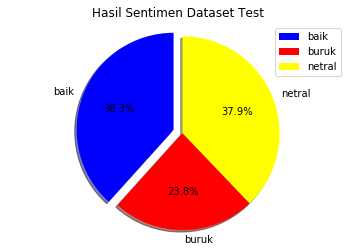

In [69]:
import matplotlib.pyplot as plt

sizes = [l_hasil.count('baik'), l_hasil.count('buruk'), l_hasil.count('netral')]
labels = ['baik','buruk','netral']
colors = ['blue', 'red', 'yellow']
explode = (0.1,0,0)

#patches, texts = plt.pie(sizes, colors=colors, startangle=-270)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.legend(labels, loc="best")
plt.title(label="Hasil Sentimen Dataset Test", loc='center')
plt.savefig('test_data_result.png', dpi=80)
plt.show()

##Step 9. Saving Model
Ketika sudah didapatkan model yang cukup baik, save model ke file. Menggunakan library Joblib dari Sklearn

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [70]:
from sklearn.externals import joblib

filename = 'finalized_model.sav'
joblib.dump(model_1, filename)
 
# some time later...
 
# load the model from disk
loaded_model = joblib.load(filename)
result = loaded_model.predict(X_test)

print(confusion_matrix(result,y_test))
print(accuracy_score(result,y_test))

[[130   9  30]
 [  6  78  21]
 [ 33  27 107]]
0.7142857142857143


## Intermezzo: Have A little fun

Coba kita prediksikan dua tweet yang konotasinya masing2 bisa dinilai sendiri. Kalau prediksi anda tidak sesuai dengan yang diharapkan berarti model anda masih ada masalah hahaha

In [87]:
coba1 = (["kalo narkoba jadi pembenaran buat urusan beban hidup, presiden kita mending rawat kebon ganja daripada pelihara kambing"])
coba2 = (["cegahlah kerusuhan dengan selalu saling pengertian tanpa memikirkan ego masing masing..ber musyawarah lah dan mufakat"])
res1 = model_1.predict(coba1)
print(res1)
res2 = model_1.predict(coba2)
print(res2)

['buruk']
['baik']



##The Challenge 1: Getting Real, Untested Dataset

Pertama-tama kita akan mengambil data dari Twitter. 
Metode ambil data yang digunakan adalah via Twitter Developer API yang terhubung dengan akun twitter saya. Metode ini sangat mudah apabila dibandingkan dengan webscraping tanpa menggunakan API.

Referensi dari dokumentasi tweepy 3.8.0.

http://docs.tweepy.org/en/latest/

Via API, didapatkan consumer key, secret key, dan access token yang digunakan untuk tersambung dengan twitter.

Tweet dicari dengan kata kunci spesifik (dalam proyek ini, saya diminta mencari sentiment mengenai Polisi) dan data yang dapat diambil berjumlah maksimum 3200 tweets dalam 15 menit (limitasi Twitter API)

Tweet disimpan dengan format JSON atau CSV dengan struktur

{tweets}
  name:
  text:
  location

In [0]:
#"""
#GET RECENT TWEETS, EXPORT TO JSON

import tweepy, json, time

# Go to http://apps.twitter.com and create an app.
# The consumer key and secret will be generated for you after
consumer_key="yq6b8RykGgWJBKyFxyb0OjBoP"
consumer_secret="nBDdrquPmKOITE4a4mzHtFf5kVwd2a1IVZc0hYuXpDbBiOITwb"

# After the step above, you will be redirected to your app's page.
# Create an access token under the the "Your access token" section
access_token="1326996704-fDpADUkOIn9jQYqwuLgZMoP4crEmUfp0ZgkGtdk"
access_token_secret="Km5vj5c6cXzOlLe2Vl7KeOQC0qPgdLUPK4TGr2PumSXtb"

auth = tweepy.auth.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth,wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

search = tweepy.Cursor(api.search, q="prabowo -filter:retweets", result_type="recent", lang="id", tweet_mode='extended').items(2500)

data = {}
data['tweets'] = []

for item in search:
  data['tweets'].append({
    'name': item.user.name,
    'text': item.full_text,
    'location': item.user.location})
  
with open('data.txt', 'w') as outfile:
    json.dump(data, outfile)

#"""

Importing into pandas dataframe

In [89]:
from pandas.io.json import json_normalize

with open('data.txt') as f:
    d = json.load(f)

data = json_normalize(d['tweets'])
data.head(3)

,location,name,text
0,,Rizky putra,@KingPurw4 Klo si goblok @KingPurw4 ini cuma b...
1,"DKI Jakarta, Indonesia",Ultra Insting,@ustadtengkuzul Terus diganti sm prabowo maksu...
2,,『I』『N』『D』『O』『N』『E』『S』『I』『A』 『M』『E』『N』『A』『N』『G』💯,@___Ghostababil_ @aniesbaswedan Mendingan foku...


In [90]:
data.count()

location    2500
name        2500
text        2500
dtype: int64

In [91]:
data.tail(3)

,location,name,text
2497,Indonesia,Senandung,"4. Menanggapi gosip tersebut, Sekjen DPP PDIP ..."
2498,Indonesia,Senandung,"2. Pertemuan Ketua Umum DPP PDI Perjuangan, Me..."
2499,Indonesia,Senandung,1. Isu Kebangsaan Menjadi Topik Pembahasan Per...


In [92]:
data.sample(5)

,location,name,text
217,,Aa Danny,"@ronavioleta @prabowo Kita lihat saja dulu, me..."
638,Jakarta Capital Region,Tagar.id,PKS Komentari Pertemuan Megawati-Prabowo https...
819,Bogor,K∆🆖 J🅰️MU#FNI,@luvanneback @InsyaAllah_02 @jokowi @aniesbasw...
1194,Bumi Pejuang,M4T BADA,@InsyaAllah_02 @dusrimulya @jokowi @aniesbaswe...
158,"Bekasi Selatan, Indonesia",JR_News,Megawati dan Jokowi Mau Pisahkan Prabowo dari ...


Variabel bebas

In [93]:
X_unseen = data.text

X_unseen.sample(3)

186     @Abid_Dzoe @janggocelebes_ @prabowo @sandiuno ...
1132    @Jhonkosmik @Dhanie7771 Buat saya semua tentan...
2087    6. Upaya itu, adalah kelanjutan dari pertemuan...
Name: text, dtype: object

##The Challenge 2: Cleaning the New Dataset

In [94]:
#get dataset tweet to empty list, run function proses_teks for every entry
x_unseen=[]
for teks in X_unseen:
    x_unseen.append(proses_teks(teks))

#save as pandas dataframe
clean_text=pd.DataFrame({'clean_tweet':x_unseen})

#concat the existing dataset dataframe with new dataframe
data=pd.concat([data,clean_text],axis=1)

X_unseen = data.clean_tweet

data.head(5)

,location,name,text,clean_tweet
0,,Rizky putra,@KingPurw4 Klo si goblok @KingPurw4 ini cuma b...,klo si goblok bisanya ngirim berita berita ber...
1,"DKI Jakarta, Indonesia",Ultra Insting,@ustadtengkuzul Terus diganti sm prabowo maksu...,diganti sm prabowo maksudnya gitu
2,,『I』『N』『D』『O』『N』『E』『S』『I』『A』 『M』『E』『N』『A』『N』『G』💯,@___Ghostababil_ @aniesbaswedan Mendingan foku...,mendingan fokus ijtima ulama
3,jakarta,pro van gaal,"@IreneViena Prabowo tak.disetujui amrik,makany...",prabowo disetujui amrik sepakat jae dorong per...
4,Indonesia,Gadun Garis Lucu,rizieq shihab enggk ada komen semenjak Prabowo...,rizieq shihab enggk komen semenjak prabowo meg...


##The Challenge 3: Predict with Previous Model Pipeline

In [0]:
filename = 'finalized_model.sav'
loaded_model = joblib.load(filename)
result = loaded_model.predict(X_unseen)

Prediksi tweet baik: 683
Prediksi tweet kurang baik: 1360
Persentase tweet baik = 27.32 %
Ketelitian = 71.43 %


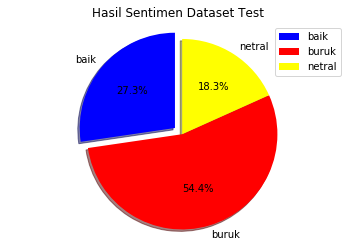

In [98]:
#Convert hasil ke list (hasil tadinya dalam bentuk ndarray)

l_result = list(result)
print("Prediksi tweet baik: " + str(l_result.count('baik')))
print("Prediksi tweet kurang baik: " + str(l_result.count('buruk')))

num = 100*(l_result.count('baik')/X_unseen.count())

print("Persentase tweet baik = {:.2f} %".format(num)) 

acc = 100*accuracy_score(hasil,y_test)

print("Ketelitian = {:.2f} %".format(acc))

import matplotlib.pyplot as plt

sizes = [l_result.count('baik'), l_result.count('buruk'), l_result.count('netral')]
labels = ['baik','buruk','netral']
colors = ['blue', 'red', 'yellow']
explode = (0.1,0,0)

#patches, texts = plt.pie(sizes, colors=colors, startangle=-270)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.legend(labels, loc="best")
plt.title(label="Hasil Sentimen Dataset Test", loc='center')
plt.savefig('test_data_result.png', dpi=80)
plt.show()

##Step 10: *Going Over the Clouds*

Pada step ini akan dilakukan proses otomasi script2 python yang kita buat dan dalam skala yang lebih besar, karena semua processing data akan dilakukan di Google Cloud Platform. Saya tidak akan menuliskan tutorial GCP di sini karena akan dibahas di post lain.

API yang dibutuhkan antara lain:

1. Google Compute Engine
2. Google Cloud Bucket Storage
3. Google Cloud Dataproc Cluster

- Spesifikasi Compute Engine VM:
  - Machine = 1-n-standard1
  - Ubuntu 18.04
  - Zone = asia-southeast1-b
  
- Spesifikasi Cloud Bucket:
  - Zone = asia-southeast1 (singapore)

- Spesifikasi Cluster VM:
  - 1 master n-nodes
  - Master = 13GB Memory, Ubuntu 18.04 Image with Spark 2.4, Anaconda installed
  - Node = 2x3.5GB Memory

 ## Step 11. Automation
 
 SSH ke Compute Engine dan buat 2 buah script:
  
  1. Python3 Script untuk scrape data dari Twitter satu hari sekali
  2. Cron Script untuk mengirim data hasil scrape ke Bucket dan otomatisasi proses tersebut

Python script yang dibuat merupakan script Tweepy yang kita sudah buat sebelumnya.

### Python Script

In [81]:
"""
#Python Script
#get_tweets.py

#GET RECENT TWEETS, EXPORT TO JSON

import tweepy, json, time

# Go to http://apps.twitter.com and create an app.
# The consumer key and secret will be generated for you after
consumer_key="yq6b8RykGgWJBKyFxyb0OjBoP"
consumer_secret="nBDdrquPmKOITE4a4mzHtFf5kVwd2a1IVZc0hYuXpDbBiOITwb"

# After the step above, you will be redirected to your app's page.
# Create an access token under the the "Your access token" section
access_token="1326996704-fDpADUkOIn9jQYqwuLgZMoP4crEmUfp0ZgkGtdk"
access_token_secret="Km5vj5c6cXzOlLe2Vl7KeOQC0qPgdLUPK4TGr2PumSXtb"

auth = tweepy.auth.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

search = tweepy.Cursor(api.search, q="prabowo", result_type="recent", lang="id", tweet_mode='extended').items(10000)

data = {}
data['tweets'] = []

for item in search:
  data['tweets'].append({
    'name': item.user.name,
    'text': item.full_text,
    'location': item.user.location})
  
with open('data.txt', 'w') as outfile:
    json.dump(data, outfile)
    
print('Done getting tweets.')
"""

'\n#Python Script\n#get_tweets.py\n\n#GET RECENT TWEETS, EXPORT TO JSON\n\nimport tweepy, json, time\n\n# Go to http://apps.twitter.com and create an app.\n# The consumer key and secret will be generated for you after\nconsumer_key="yq6b8RykGgWJBKyFxyb0OjBoP"\nconsumer_secret="nBDdrquPmKOITE4a4mzHtFf5kVwd2a1IVZc0hYuXpDbBiOITwb"\n\n# After the step above, you will be redirected to your app\'s page.\n# Create an access token under the the "Your access token" section\naccess_token="1326996704-fDpADUkOIn9jQYqwuLgZMoP4crEmUfp0ZgkGtdk"\naccess_token_secret="Km5vj5c6cXzOlLe2Vl7KeOQC0qPgdLUPK4TGr2PumSXtb"\n\nauth = tweepy.auth.OAuthHandler(consumer_key, consumer_secret)\nauth.set_access_token(access_token, access_token_secret)\n\napi = tweepy.API(auth, wait_on_rate_limit=True)\n\nsearch = tweepy.Cursor(api.search, q="prabowo", result_type="recent", lang="id", tweet_mode=\'extended\').items(10000)\n\ndata = {}\ndata[\'tweets\'] = []\n\nfor item in search:\n  data[\'tweets\'].append({\n    \'nam

berikutnya, masuk ke crontab lewat python virtual environment.

Guide memasang virtualenv python:

https://packaging.python.org/guides/installing-using-pip-and-virtualenv/

kemudian masuk ke virtualenv dan buka crontab di

```
crontab -e
```

atau


```
sudo crontab -e
```

### Crontab script


```
00 12 * * * python3 /home/sandw/twitter_sa/get_tweets.py 

30 12 * * * sudo gsutil cp /home/sandw/twitter_sa/data.txt gs://twitter-sa-bucket/data_unseen/
```

script ini akan menjalankan get_tweets.py setiap pukul 12:00 setiap harinya dan menjalankan command pindahkan data.txt ke cloud bucket setiap pukul 12:30 setiap harinya.


## Step 12. Storing in the Bucket